<a href="https://colab.research.google.com/github/oferbaharav/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Copy_of_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
import pandas as pd
test = pd.Series(['bla', 'blo', 'ble', 'blu', 'bli'])
print(test)

0    bla
1    blo
2    ble
3    blu
4    bli
dtype: object


In [6]:
test2 = ['bla', 'blo', 'ble', 'blu', 'bli']
test2

['bla', 'blo', 'ble', 'blu', 'bli']

In [7]:
test3 = [['bla', 'blo', 'ble', 'blu', 'bli',
            'bla', 'blo', 'ble', 'blu', 'bli']]
test3


[['bla', 'blo', 'ble', 'blu', 'bli', 'bla', 'blo', 'ble', 'blu', 'bli']]

In [8]:
test[0]

'bla'

In [9]:
import numpy as np

test4 =pd.DataFrame({'a': [2, np.nan, 8, 3], 'b': [np.nan, 32, 15, 7], 'c': [-3, 5, 22, 19]})
test4

,a,b,c
0,2.0,NaN,-3
1,NaN,32.0,5
2,8.0,15.0,22
3,3.0,7.0,19


In [10]:
test4.dropna(axis=0, inplace=True)
test4

,a,b,c
2,8.0,15.0,22
3,3.0,7.0,19


In [11]:
test4 = test4.dropna(axis=0)
test4

,a,b,c
2,8.0,15.0,22
3,3.0,7.0,19


In [12]:
#  Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' 
#and the sale price was more than 100 thousand and less than 2 million.
df.head(2)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019


In [26]:
df1 = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]
df1.head(2)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01


In [27]:
df1.SALE_DATE.max()

Timestamp('2019-04-30 00:00:00')

In [28]:
df1.SALE_DATE.min()

Timestamp('2019-01-01 00:00:00')

In [0]:
#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.


In [0]:
# the most extreme .1% longitudes
df = df[(df['SALE_PRICE'] >= np.percentile(df['SALE_PRICE'], 0.5)) & 
        (df['SALE_PRICE'] <= np.percentile(df['SALE_PRICE'], 99.5))]
       

(2507, 21) (644, 21)


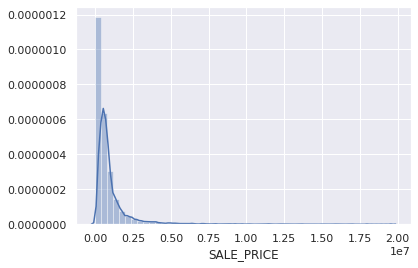

In [33]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('04/01/2019')
train = df1[df1.SALE_DATE < cutoff]
test = df1[df1.SALE_DATE >= cutoff]
print(train.shape, test.shape)
AX = sns.distplot(df['SALE_PRICE'])





In [34]:
train.select_dtypes(exclude='number').describe().T 

,count,unique,top,freq,first,last
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,6,OTHER,2382,NaT,NaT
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
ADDRESS,2507,2497,33 BAILEY PLACE,2,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [46]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET']
features = train.columns.drop([target] + high_cardinality)

x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]



KeyError: ignored

In [36]:
train.select_dtypes(exclude = 'number').describe().T

,count,unique,top,freq,first,last
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,6,OTHER,2382,NaT,NaT
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
ADDRESS,2507,2497,33 BAILEY PLACE,2,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [37]:
!pip install category_encoders

In [38]:
#do one hot encoding of categorical features
import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)
train = encoder.fit_transform(train)
test = encoder.transform(test)
train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ADDRESS_4832 BAY PARKWAY,ADDRESS_80-23 232ND STREET,ADDRESS_1260 RHINELANDER AVE,ADDRESS_469 E 25TH ST,ADDRESS_5521 WHITTY LANE,ADDRESS_1747 EAST 23RD STREET,ADDRESS_1582 EAST 15TH STREET,ADDRESS_201-08 50TH AVENUE,ADDRESS_85-11 57 ROAD,ADDRESS_53-19 198TH STREET,...,"LAND_SQUARE_FEET_1,293","LAND_SQUARE_FEET_2,708","LAND_SQUARE_FEET_2,233","LAND_SQUARE_FEET_2,260","LAND_SQUARE_FEET_5,005","LAND_SQUARE_FEET_1,235","LAND_SQUARE_FEET_4,298","LAND_SQUARE_FEET_1,060",LAND_SQUARE_FEET_946,"LAND_SQUARE_FEET_1,698","LAND_SQUARE_FEET_3,990","LAND_SQUARE_FEET_3,012","LAND_SQUARE_FEET_2,231","LAND_SQUARE_FEET_4,485","LAND_SQUARE_FEET_1,918","LAND_SQUARE_FEET_2,020","LAND_SQUARE_FEET_1,380","LAND_SQUARE_FEET_3,338","LAND_SQUARE_FEET_3,692","LAND_SQUARE_FEET_2,755","LAND_SQUARE_FEET_3,230","LAND_SQUARE_FEET_2,121","LAND_SQUARE_FEET_4,361","LAND_SQUARE_FEET_3,910",GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,SALE_PRICE,SALE_DATE
44,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5495,801,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0,550000,2019-01-01
61,0,1,0,0,0,1,0,0,0,0,0,1,1,0,7918,72,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0,200000,2019-01-01
78,0,0,1,0,0,1,0,0,0,0,0,1,1,0,4210,19,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0,810000,2019-01-02
108,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5212,69,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0,125000,2019-01-02
111,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7930,121,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0,620000,2019-01-02


In [43]:
#feature selection, picking the top 15
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func = f_regression, k=15)
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)


ValueError: ignored

In [0]:
#  Do feature selection with SelectKBest.

def engineer_features(X):
    
    # Avoid SettingWithCopyWarning
    X = X.copy()
    
    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    X['perk_count'] = X[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    X['cats_or_dogs'] = (X['cats_allowed']==1) | (X['dogs_allowed']==1)

    # Are cats and dogs allowed?
    X['cats_and_dogs'] = (X['cats_allowed']==1) & (X['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    X['rooms'] = X['bedrooms'] + X['bathrooms']

    return X

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)



In [0]:
#  Do feature scaling. Use the scaler's fit_transform method with the train set. Use the scaler's transform method with the test set.


In [0]:
#  Fit a ridge regression model with multiple features.


In [0]:
#  Get mean absolute error for the test set.


In [0]:
#  As always, commit your notebook to your fork of the GitHub repo.